[*********************100%%**********************]  4 of 4 completed
C:\Users\PC\AppData\Local\Temp\ipykernel_17548\2367369198.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = (portfolio_return - 0.01) / portfolio_std_dev  # Assuming 1% risk-free rate


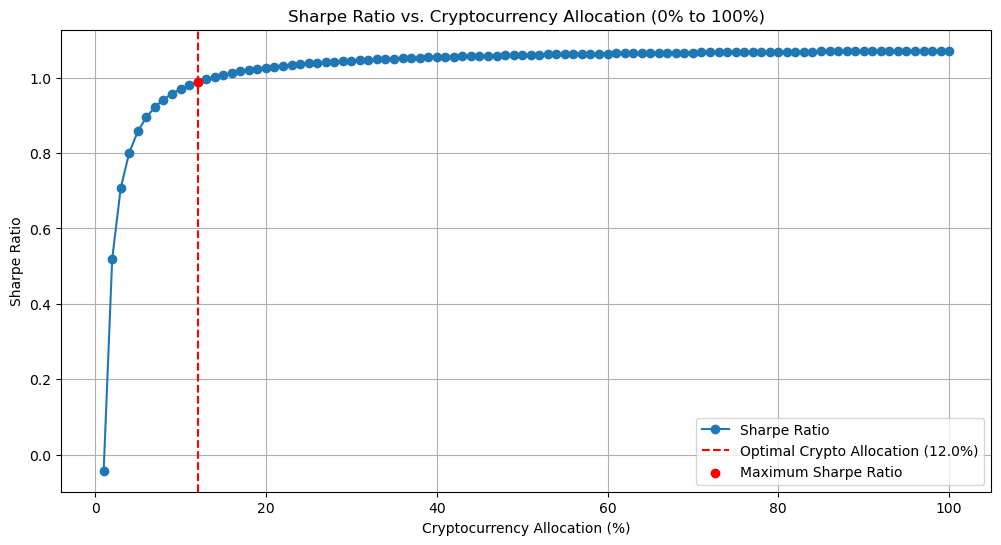

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Data Collection
assets = ['BTC-USD', 'ETH-USD', '^GSPC', 'AGG']  # Cryptos, S&P 500, Bonds
data = yf.download(assets, start='2015-09-01', end='2024-04-30')['Adj Close']

# Step 2: Align Trading Days
data = data.dropna()  # Drop rows with missing values to align trading days

# Step 3: Calculate Returns
returns = data.pct_change().dropna()

# Step 4: Define Portfolio Metrics Function
def portfolio_metrics(weights, returns, crypto_only=False):
    weights = np.array(weights)  # Ensure weights is a NumPy array
    annual_factor = 365 if crypto_only else 252
    portfolio_return = np.dot(weights, returns.mean()) * annual_factor
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))) * np.sqrt(annual_factor)
    sharpe_ratio = (portfolio_return - 0.01) / portfolio_std_dev  # Assuming 1% risk-free rate
    return portfolio_return, portfolio_std_dev, sharpe_ratio

# Step 5: Cryptocurrency Portfolio (0% to 100%)
crypto_only_results = []
crypto_allocation_range = np.linspace(0, 1, 101)  # From 0% to 100% in 1% increments

for crypto_allocation in crypto_allocation_range:
    crypto_weights = [crypto_allocation * 0.60, crypto_allocation * 0.40]  # 60% BTC, 40% ETH
    portfolio_return, portfolio_std_dev, sharpe_ratio = portfolio_metrics(crypto_weights, returns[['BTC-USD', 'ETH-USD']], crypto_only=True)
    crypto_only_results.append({
        'Crypto Allocation': crypto_allocation,
        'Portfolio Return': portfolio_return,
        'Portfolio Volatility': portfolio_std_dev,
        'Sharpe Ratio': sharpe_ratio
    })

# Convert to DataFrame
crypto_only_df = pd.DataFrame(crypto_only_results)

# Step 6: Marginal Contribution of Sharpe Ratio
crypto_only_df['Delta Sharpe'] = crypto_only_df['Sharpe Ratio'].diff()
crypto_only_df['Marginal Sharpe (%)'] = crypto_only_df['Delta Sharpe'] / (crypto_only_df['Crypto Allocation'].diff() * 100)

# Find Optimal Cryptocurrency Allocation
threshold = 0.01  # Marginal contribution threshold (e.g., proportional to 1% of the Sharpe ratio)
optimal_point = crypto_only_df[crypto_only_df['Marginal Sharpe (%)'] < threshold].iloc[0]

# Step 7: Plot Results
# Plot 1: Sharpe Ratio vs. Cryptocurrency Allocation with the Optimal Point Highlighted
plt.figure(figsize=(12, 6))
plt.plot(crypto_only_df['Crypto Allocation'] * 100, crypto_only_df['Sharpe Ratio'], marker='o', label='Sharpe Ratio')
plt.axvline(optimal_point['Crypto Allocation'] * 100, color='red', linestyle='--', 
            label=f'Optimal Crypto Allocation ({optimal_point["Crypto Allocation"] * 100:.1f}%)')
plt.scatter(optimal_point['Crypto Allocation'] * 100, optimal_point['Sharpe Ratio'], 
            color='red', zorder=5, label='Maximum Sharpe Ratio')
plt.title('Sharpe Ratio vs. Cryptocurrency Allocation (0% to 100%)')
plt.xlabel('Cryptocurrency Allocation (%)')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid()
plt.show()
